SENT TO ME BY YAEL B.H.

In [1]:
from qiskit import IBMQ
import os
import csv
import datetime
IBMQ.load_account()
provider = IBMQ.get_provider(hub= 'ibm-q')
log_time = datetime.datetime.now()
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#avoid qasm_simulator
backends = list(map( lambda x: x.name(), provider.backends()))[1:]


C:\Users\Annanay\Anaconda3\envs\project\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
backend = provider.get_backend('ibmq_armonk')

In [3]:
backend.properties(datetime=datetime.datetime(2020,9,13,15,0,0)).qubits

<ipython-input-3-c50e5118f011>:1: UserWarning: Unless a UTC timezone information is present, the parameter `datetime`is now expected to be in local time instead of UTC.
  backend.properties(datetime=datetime.datetime(2020,9,13,15,0,0)).qubits


[[Nduv(datetime.datetime(2020, 9, 13, 14, 40, 57, tzinfo=tzlocal()), T1, us, 176.27576614079643),
  Nduv(datetime.datetime(2020, 9, 13, 14, 52, 16, tzinfo=tzlocal()), T2, us, 197.17797154341824),
  Nduv(datetime.datetime(2020, 9, 13, 14, 55, 1, tzinfo=tzlocal()), frequency, GHz, 4.974449667392958),
  Nduv(datetime.datetime(2020, 9, 13, 14, 55, 1, tzinfo=tzlocal()), anharmonicity, GHz, 0),
  Nduv(datetime.datetime(2020, 9, 13, 14, 29, 45, tzinfo=tzlocal()), readout_error, , 0.05590000000000006),
  Nduv(datetime.datetime(2020, 9, 13, 14, 29, 45, tzinfo=tzlocal()), prob_meas0_prep1, , 0.0516),
  Nduv(datetime.datetime(2020, 9, 13, 14, 29, 45, tzinfo=tzlocal()), prob_meas1_prep0, , 0.06020000000000003)]]

https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.IBMQBackend.properties.html?highlight=backend%20properties#qiskit.providers.ibmq.IBMQBackend.properties

https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendProperties.html

In [ ]:
def write_log_to_file(csv_writer):
    for backend in map(lambda x: provider.get_backend(x),backends):
        try:
            """
            Class representing name-date-unit-value
            Attributes:
                date: date (datetime.datetime)
                name: name. (str)
                unit: unit. (str)
                value: value. (float)
            qubit_idx is a single digit integer; 
            qubit_prop is a list of Nduv
            """
            for qubit_idx, qubit_prop in enumerate(backend.properties(refresh=True).qubits):
                for prop in qubit_prop:
                    csv_writer.writerow([backend.name(), qubit_idx, prop.date.isoformat(), prop.name, prop.unit, prop.value, log_time.isoformat()])
                id_gate = [i for i in backend.properties().gates if i.gate =='id' and qubit_idx in i.qubits][0]
                id_gate_length = [p for p in id_gate.parameters if p.name=='gate_length'][0]
                csv_writer.writerow([backend.name(), qubit_idx, id_gate_length.date.isoformat(), 'id_length',
                                     id_gate_length.unit, id_gate_length.value, log_time.isoformat()])
        except Exception as e:
            print("Cannot add backend", backend.name(), e)


In [ ]:

absolute_path = 'C:\\Users\\Annanay\\OneDrive\\Documents\\Work\\project\\data_and_scripts\\' + log_time.strftime("%d") + '_' + log_time.strftime('%m') + '.csv'
if not os.path.isfile(absolute_path):
    with open(absolute_path, "w") as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(["backend","qubit","datetime","name","units","value","log_datetime"])
        write_log_to_file(csv_writer)
else :
    with open(absolute_path, "a") as f:
        write_log_to_file(csv.writer(f))


In [ ]:
"""
Get update schedules for each backend for last 1 month. Heirarchy:
Backend --- qubits --- all qubit properties
                  --- gates --- gate_error, gate_length
                  
Could definitely be made more efficient by ensuring no duplicates are added
(rather than just dropping them at the end)
"""
current_time = datetime.datetime.now()
prev_time = datetime.datetime(2020,5,20,12,0,0)
results = pd.DataFrame({}, columns=['backend','qubit', 'gate','prop_name', 'prop_time'])

while current_time > prev_time: 
    for backend in map(lambda x: provider.get_backend(x),backends):
        try:
                """
                Class representing name-date-unit-value
                Attributes:
                    date: date (datetime.datetime)
                    name: name. (str)
                    unit: unit. (str)
                    value: value. (float)
                qubit_idx is a single digit integer; 
                qubit_prop is a list of Nduv
                """
                PROPS = backend.properties(refresh=True, datetime = current_time)
                for qubit_idx, qubit_prop in enumerate(PROPS.qubits):
                    #qubit properties first
                    results = results.append(pd.DataFrame({
                        'backend': [backend.name() for i in qubit_prop],
                        'qubit': [qubit_idx for i in qubit_prop],
                        'gate': [None for i in qubit_prop],
                        'prop_name': [prop.name for prop in qubit_prop],
                        'prop_time': [prop.date for prop in qubit_prop]
                    }, columns=['backend','qubit', 'gate','prop_name', 'prop_time']))

                    #then gate properties. Note that 2-qubit gates get a repeat entry
                    #(one for each qubit they act on)
                    for gate in [i for i in PROPS.gates if qubit_idx in i.qubits]:
                        results = results.append(pd.DataFrame({
                            'backend': [backend.name() for i in gate.parameters],
                            'qubit': [qubit_idx for i in gate.parameters],
                            'gate': [gate.gate for i in gate.parameters],
                            'prop_name': [i.name for i in gate.parameters],
                            'prop_time': [i.date for i in gate.parameters]
                        }, columns=['backend','qubit', 'gate','prop_name', 'prop_time']))

        except Exception as e:
            print("Cannot add backend", backend.name(), current_time, e)


        current_time -= datetime.timedelta(seconds = 1800)

results.drop_duplicates(inplace=True)
results.to_csv('update_schedule.csv',index=False)

In [3]:
def convert_to_datetime(bad_str):
    """
    Converts the muddled time data strings from CSV to datetime objects
    """
    try:
        try:
            return (datetime.datetime.strptime(str(bad_str)[:str(bad_str).index('+')], '%Y-%m-%dT%H:%M:%S'))
        except:
            return (datetime.datetime.strptime(str(bad_str)[:str(bad_str).index('+')], '%Y-%m-%d %H:%M:%S'))
    except Exception as e:
        print('ERROR ERROR', bad_str, e)

#results = pd.read_csv('update_schedule.csv')
#results['prop_time']= results['prop_time'].apply(convert_to_datetime)

In [ ]:
    """
    CHANGE PROPERTIES HERE
    """
plot = results[(results['backend'] == 'ibmqx2') & (results['prop_name'] == 'gate_length') & (results['qubit'] == 4)].reset_index(drop=True).iloc[::-1]
plot['timestamp'] = plot['prop_time'].apply(lambda x: datetime.datetime.timestamp(x))
del plot['prop_name']
del plot ['prop_time']
plot.to_csv('plot1.csv', index=False)

In [ ]:
from operator import itemgetter
from collections import defaultdict


def plot_timeline(dataset, **kwargs):
    """
    Plots a timeline of events from different sources to visualize a relative
    sequence or density of events. Expects data in the form of:
        (timestamp, source, category {colour})
    Though this can be easily modified if needed. Expects sorted input.
    Taken from https://bbengfort.github.io/snippets/2016/01/29/timeline-visualization.html
    """
    outpath = kwargs.pop('savefig', None)  # Save the figure as an SVG
    colors  = kwargs.pop('colors', {})     # Plot the colors for the series.
    series  = set([])                      # Figure out the unique series

    # Bring the data into memory and sort
    dataset = list(dataset)

    # Make a first pass over the data to determine number of series, etc.
    for _, source, category in dataset:
        series.add(source)
        if category not in colors:
            colors[category] = 'k'

    # Sort and index the series
    series  = sorted(list(series))

    # Create the visualization
    x = []  # Scatterplot X values
    y = []  # Scatterplot Y Values
    c = []  # Scatterplot color values

    # Loop over the data a second time
    for timestamp, source, category in dataset:
        x.append(datetime.datetime.fromtimestamp(timestamp))
        y.append(series.index(source))
        c.append(colors[category])

    plt.figure(figsize=(14,4))
    """
    CHANGE TITLE HERE
    """
    plt.title(kwargs.get('title', "Qubit 4 Gate Length Update Schedule"))
    #plt.ylim((-1,len(series)))
    #plt.xlim((-1000, dataset[-1][0]+1000))
    plt.yticks(range(len(series)), series)
    plt.scatter(x, y, color=c, alpha=0.85, s=10)

    if outpath:
        return plt.savefig(outpath, format='svg', dpi=1200)

    return plt


colors = {'ibmqx2': 'r'}
with open('plot1.csv', 'r') as f:
    reader = csv.reader(f)
    plt = plot_timeline([
        (float(row[0]), row[1], row[2])
        for row in reader
    ], colors=colors)
plt.gca().xaxis.grid(True)
plt.show()


In [2]:
import itertools
import operator

def get_first_time(backends):
    """
    Gets first available backend.properties() instance available
    for given backend, in dictionary form, via BINARY SEARCH between
    now and online_date.
    Expects BackendObject arguments
    """
    answers=[]
    for backend in backends:
        #search space
        times = [backend.configuration().online_date.replace(tzinfo=None) + datetime.timedelta(days=i) 
                 for i in range((datetime.datetime.now()- backend.configuration().online_date.replace(tzinfo=None)).days)]
        
        #binary search
        lb = 0
        ub = len(times)
        while lb != ub:
            temp = int(np.floor((lb+ub)/2))
            if backend.properties(refresh = True, datetime = times[int(np.floor((lb+ub)/2))]) == None:
                lb = temp + 1
            else:
                ub = temp

        answers.append(times[lb])
    
    return (dict(zip(backends,answers)))


def merge_dols(one, two):

    from collections import defaultdict
    from itertools import chain
    from operator import methodcaller


    # initialise defaultdict of lists
    dd = defaultdict(list)

    # iterate dictionary items
    dict_items = map(methodcaller('items'), (one, two))
    for k, v in chain.from_iterable(dict_items):
        dd[k].extend(v)
    
    return(dd)

    
def get_errors(gates, prop):
    """
    Returns dict of {prop_value: , prop_time: , prop_quality} for gate_error
    
    """
    #flattened list of all gate properties nduvs
    gates_props = [item for sublist in gates for item in sublist]
    errors = {i.value: i.date for i in gates_props if i.name == prop}
    
    #NB the datetime for the mean prop_time is naturally an estimate.
    ans = {'prop_value': [min(errors.keys()), max(errors.keys()), np.mean(list(map(float,errors.keys())))], 
           'prop_time': [errors[min(errors.keys())], errors[max(errors.keys())], list(errors.values())[0]], 
           'prop_quality': ['best', 'worst', 'mean']}
    return(ans)

In [108]:
"""
For each machine, plot average, best and worst of:
id_gate_error, CX_gate_error, T1, T2, readout error
for as long a period as possible
"""
cols = ['backend', 'prop_quality','prop_name', 'prop_value', 'prop_time']
backends = list(provider.backends())[1:]
first_times = get_first_time(backends)
results = dict(zip(cols,[[] for i in cols]))

for backend in backends:
    current_time = datetime.datetime.now()
    while current_time > first_times[backend]:
        try:
            """
            Class representing name-date-unit-value
            Attributes:
                date: date (datetime.datetime)
                name: name. (str)
                unit: unit. (str)
                value: value. (float)
            qubit_idx is a single digit integer; 
            qubit_prop is a list of Nduv
            """
            PROPS = backend.properties(refresh=True, datetime = current_time)

            id_gates = get_errors(list(map(lambda x: x.parameters, [i for i in PROPS.gates if i.gate =='id'])), 'gate_error')
            id_error = { 'prop_name': ['id_error']*3, **id_gates}
            cx_gates = get_errors(list(map(lambda x: x.parameters, [i for i in PROPS.gates if i.gate =='cx'])), 'gate_error')
            cx_error = {'prop_name': ['cx_error']*3, **cx_gates}
            errors = merge_dols(id_error,cx_error)

            for err in  ['T1', 'T2', 'readout_error']:
                errors = merge_dols(errors, {'prop_name': [err]*3, **get_errors(PROPS.qubits, err)})
            results = merge_dols(results, {'backend': [backend.name()]*len(errors['prop_name']), **errors})
        except Exception as e:
            print("Cannot add backend", backend.name(), current_time, e)

        current_time -= datetime.timedelta(days=1)


Cannot add backend ibmqx2 2020-03-19 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2020-03-18 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-26 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-25 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-24 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-23 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-22 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-21 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-20 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-19 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-18 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-08-17 21:13:23.594806 min() arg is an empty s

Cannot add backend ibmqx2 2019-05-22 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-21 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-20 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-19 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-18 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-17 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-16 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-15 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-14 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-13 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-12 21:13:23.594806 min() arg is an empty sequence
Cannot add backend ibmqx2 2019-05-11 21:13:23.594806 min() arg is an empty s

Cannot add backend ibmq_16_melbourne 2019-12-20 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-19 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-18 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-17 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-16 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-15 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-14 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-13 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-12 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-11 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-12-10 21

Cannot add backend ibmq_16_melbourne 2019-09-24 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-23 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-22 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-21 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-20 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-19 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-18 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-17 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-16 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-15 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-09-14 21

Cannot add backend ibmq_16_melbourne 2019-06-28 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-27 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-26 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-25 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-24 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-23 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-22 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-21 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-20 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-19 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-06-18 21

Cannot add backend ibmq_16_melbourne 2019-04-02 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-04-01 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-31 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-30 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-29 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-28 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-27 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-26 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-25 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-24 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-03-23 21

Cannot add backend ibmq_16_melbourne 2019-01-05 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-01-04 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-01-03 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-01-02 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2019-01-01 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2018-12-31 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2018-12-30 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2018-12-29 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2018-12-28 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2018-12-27 21:17:32.255662 min() arg is an empty sequence
Cannot add backend ibmq_16_melbourne 2018-12-26 21

Cannot add backend ibmq_armonk 2020-05-04 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-05-03 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-05-02 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-05-01 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-30 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-29 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-28 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-27 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-26 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-25 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-04-24 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ib

Cannot add backend ibmq_armonk 2020-02-01 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-31 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-30 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-29 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-28 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-27 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-26 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-25 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-24 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-23 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ibmq_armonk 2020-01-22 21:35:31.899921 min() arg is an empty sequence
Cannot add backend ib

In [109]:
results = pd.DataFrame(results, columns=cols)
results.to_csv('fidelity_change.csv', index=False)

In [4]:
results = pd.read_csv('fidelity_change.csv')
results.drop('Unnamed: 0', inplace=True, axis=1)
results['prop_time'] = results['prop_time'].apply(convert_to_datetime)

In [27]:
results.iloc[0].prop_time

Timestamp('2020-07-04 08:28:13')

In [5]:
errors = [[ [results.loc[3*k+2].prop_value - results.loc[3*k+1].prop_value for k in range(10295)],
           [results.loc[3*k+2].prop_value - results.loc[3*k].prop_value for k in range(10295)] ]]
results = results[(results['prop_name'] != 'id_error') | (results['prop_value'] > 0)]
results = results[(results['prop_name'] != 'id_error') | (results['prop_value'] < 0.5)]
results = results[(results['prop_name'] != 'cx_error') | (results['prop_value'] > 0)]
results = results[(results['prop_name'] != 'cx_error') | (results['prop_value'] < 0.5)]
results = results[(results['prop_name'] != 'readout_error') | (results['prop_value'] > 0)]
results = results[(results['prop_name'] != 'readout_error') | (results['prop_value'] < 0.5)]
results = results[(results['prop_name'] != 'T1') | (results['prop_value'] > 0)]

In [7]:
results.to_csv('fidelity_change_clean.csv')

In [34]:
plot = results[(results['prop_quality'] == 'mean')]

In [51]:
results[results['backend']=='ibmqx2']

,backend,prop_quality,prop_name,prop_value,prop_time
0,ibmqx2,best,id_error,0.000486,2020-07-04 08:28:13
1,ibmqx2,worst,id_error,0.000940,2020-07-04 08:25:37
2,ibmqx2,mean,id_error,0.000636,2020-07-04 08:22:51
3,ibmqx2,best,cx_error,0.011483,2020-07-04 08:49:23
4,ibmqx2,worst,cx_error,0.021503,2020-07-04 08:40:29
...,...,...,...,...,...
4660,ibmqx2,worst,T2,63.666587,2019-08-27 02:59:49
4661,ibmqx2,mean,T2,45.645156,2019-08-27 02:58:08
4662,ibmqx2,best,readout_error,0.026900,2019-08-27 02:56:36
4663,ibmqx2,worst,readout_error,0.086450,2019-08-27 02:56:36


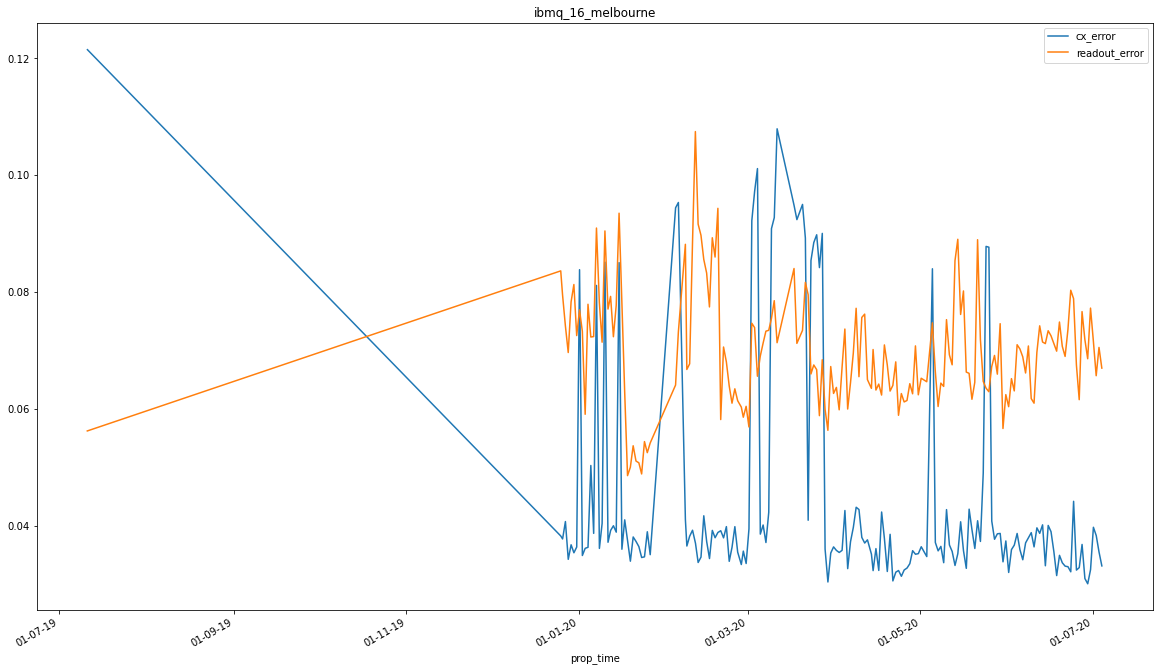

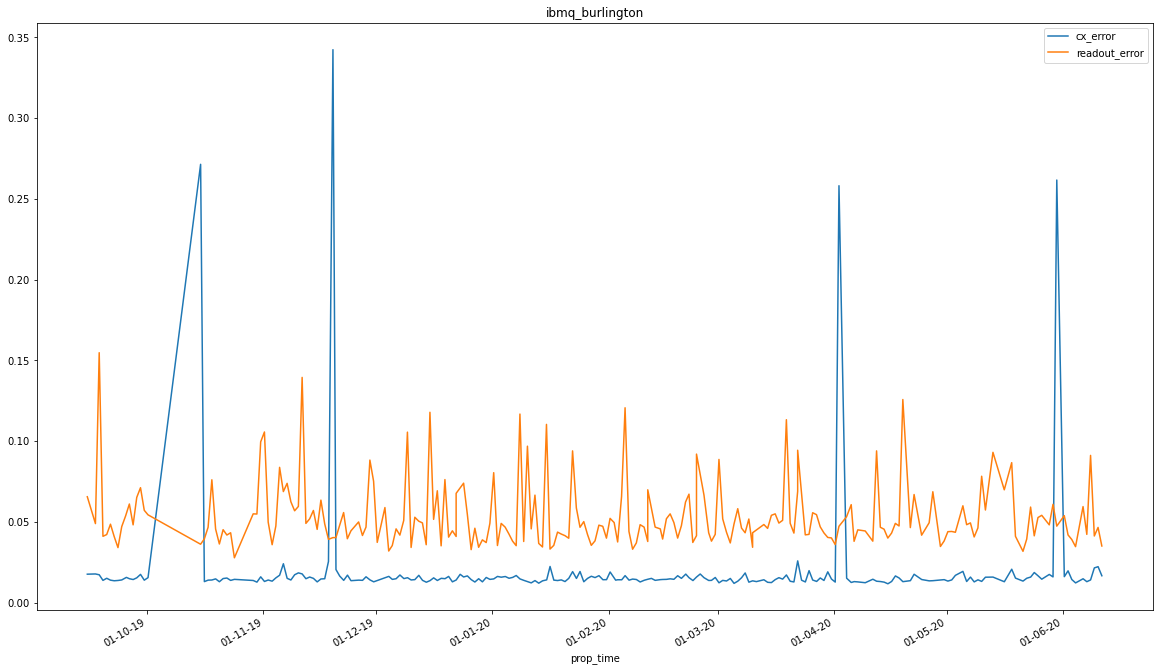

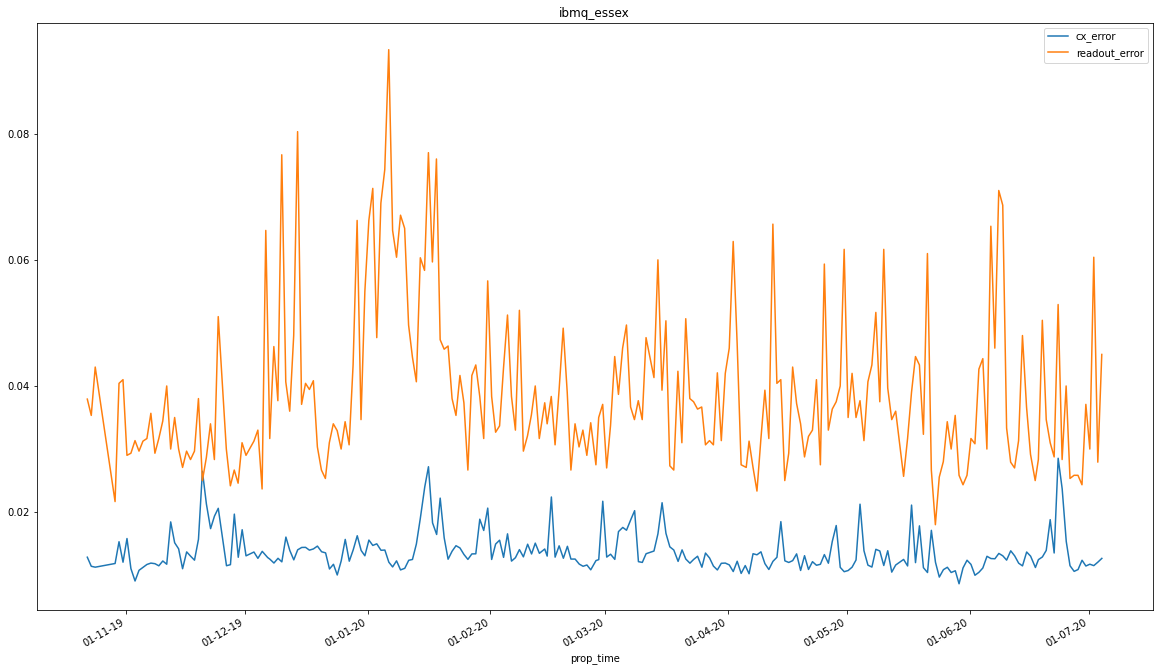

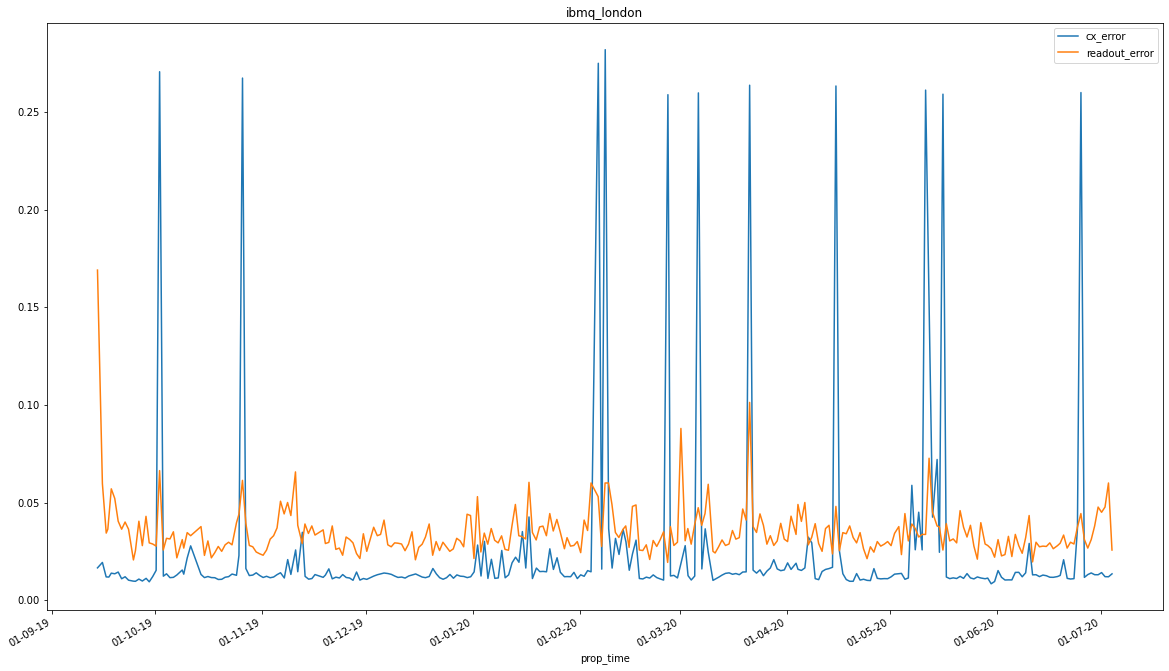

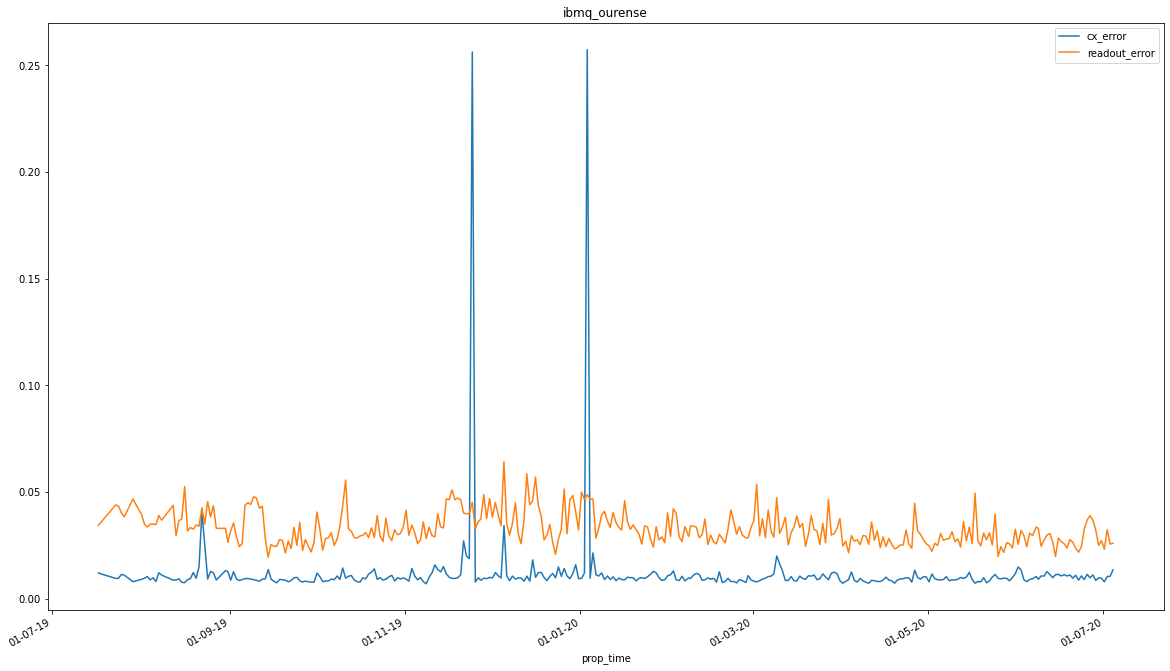

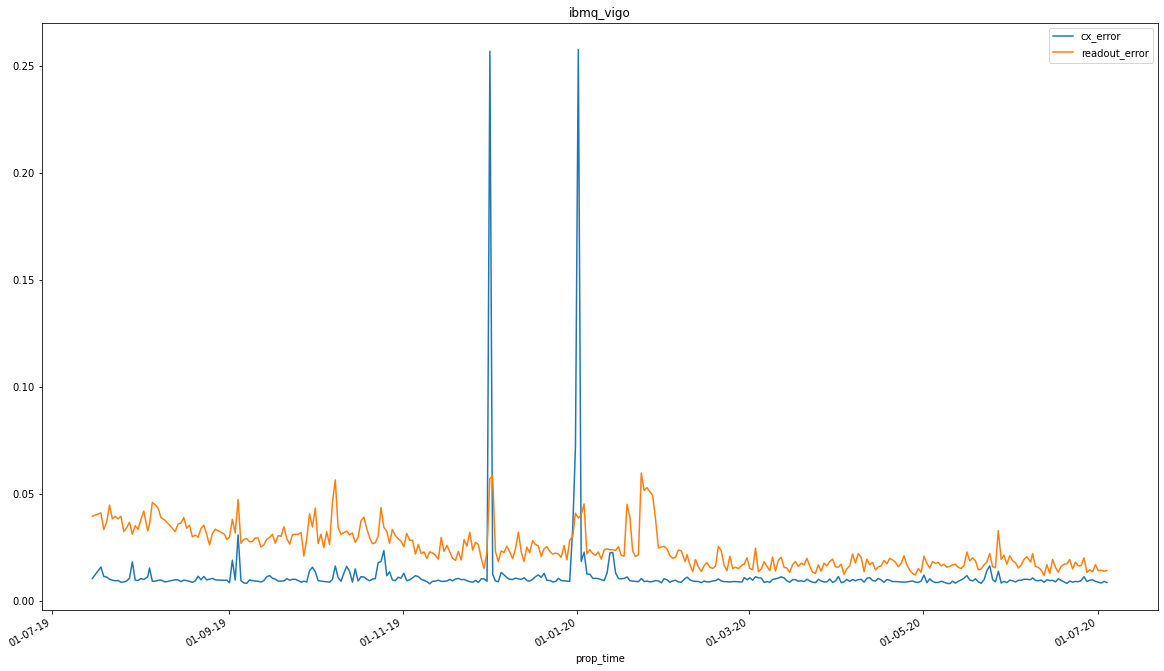

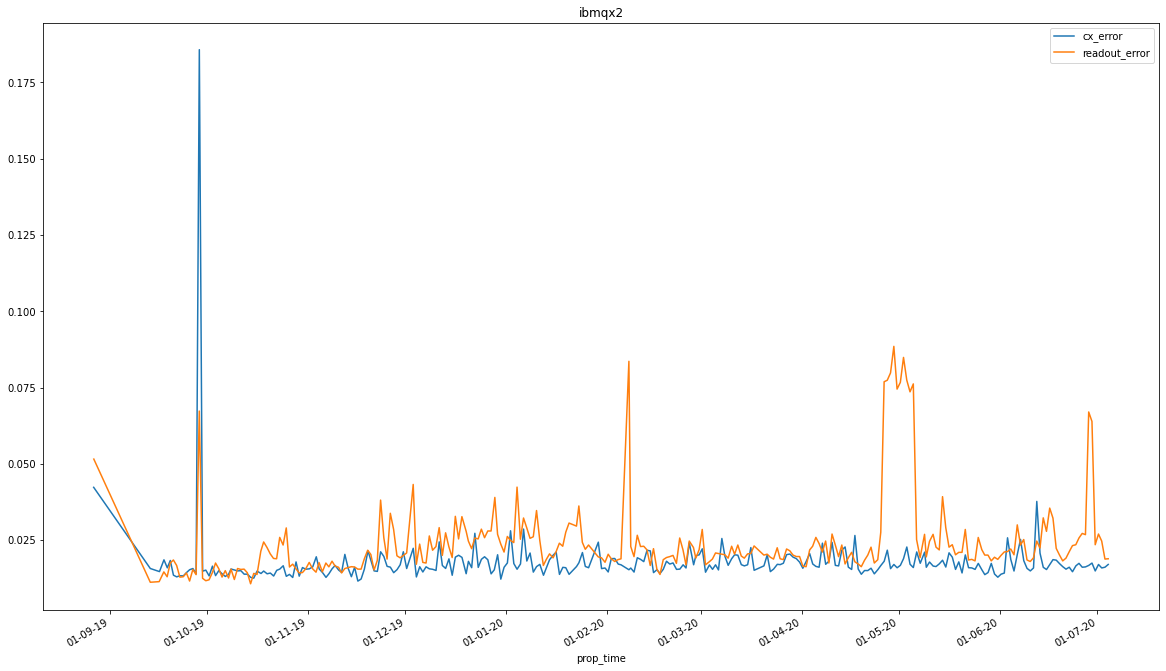

In [58]:
import matplotlib.dates as mdates



for backend_key, grp in plot.groupby(['backend']):
    fig, ax = plt.subplots()
    xfmt = mdates.DateFormatter("%d-%m-%y")
    ax.xaxis.set_major_formatter(xfmt)
    for error_key, plot1 in grp.groupby(['prop_name']):
        if error_key != 'T2' and error_key != 'T1' and error_key != 'id_error':    
            ax = plot1.plot(ax=ax, kind='line', x='prop_time', y='prop_value', label=error_key, figsize=(20,12))
    plt.title(backend_key)
    plt.legend()
    plt.show()

In [47]:
np.array(errors).shape

(1, 2, 10295)